In [1]:
import cv2 as cv
import numpy as np
from IPython.display import Image, display
import math
from numpy.linalg import norm

In [2]:
import PIL.Image
import io
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [ ]:
# Read video into array, 

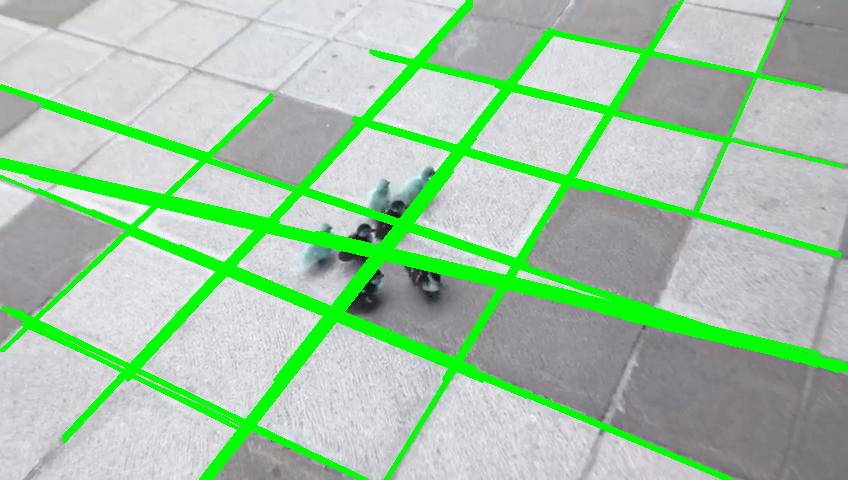

In [7]:
file = 'patitos.mp4'
cap = cv.VideoCapture(file)

for _ in range(400):
    ret, frame = cap.read()
orig_img = frame.copy()
edges = cv.Canny(frame,50,250)
edges = cv.dilate(edges.astype('uint8'), np.ones((2,2), np.uint8), iterations=3)
#edges = cv.blur(edges, (2,2))

lines = cv.HoughLinesP(edges, 2, math.radians(0.1), 400, minLineLength=200, maxLineGap=20)
line_img = frame.copy()
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv.line(line_img,(x1,y1),(x2,y2),(0,255,0),2)
showarray(line_img)

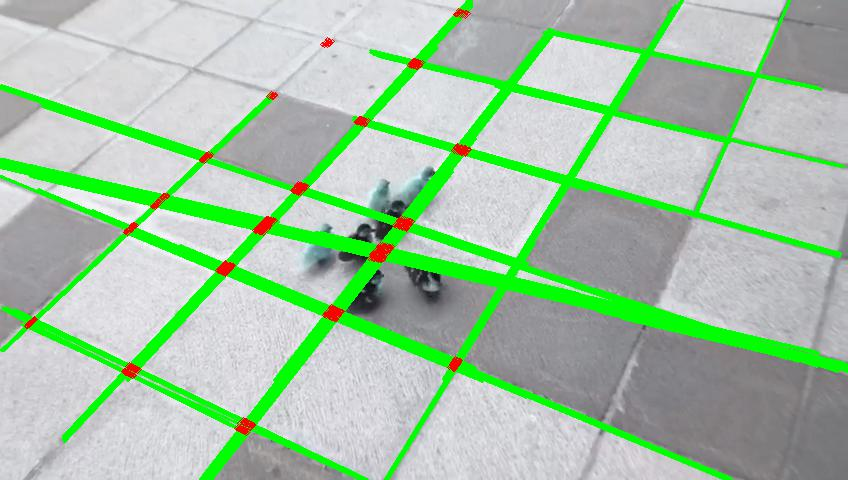

In [8]:
from skspatial.objects import Line

def check_intersection(line1, line2):
    line1_sk = Line.from_points(line1[:2], line1[2:])
    line2_sk = Line.from_points(line2[:2], line2[2:])

    try:
        intersect = line1_sk.intersect_line(line2_sk)
    except ValueError:
        return False, None

    return True, intersect

def cos_similarity(line1, line2):
    A = np.array(line1[:2] - line1[2:])
    B = np.array(line2[:2] - line2[2:])
    return np.dot(A,B)/(norm(A) * norm(B))

points = []
for i,l1 in enumerate(lines):
    for j,l2 in enumerate(lines):
        if i == j:
            continue

        similarity = cos_similarity(l1[0], l2[0])
        #print(l1[0][2])
        has_intersect, point = check_intersection(l1[0].astype(float), l2[0].astype(float))
        if has_intersect and similarity < 0.6:
            oob = np.any(point > frame.shape[:2]) | np.any(point < 0)
            if not oob:
                points.append(point)


point_frame = line_img.copy()
for point in points:
    cv.circle(point_frame, center=(point[0].astype('uint32'), point[1].astype('uint32')), radius=2, color=(255,0,0))
showarray(point_frame)

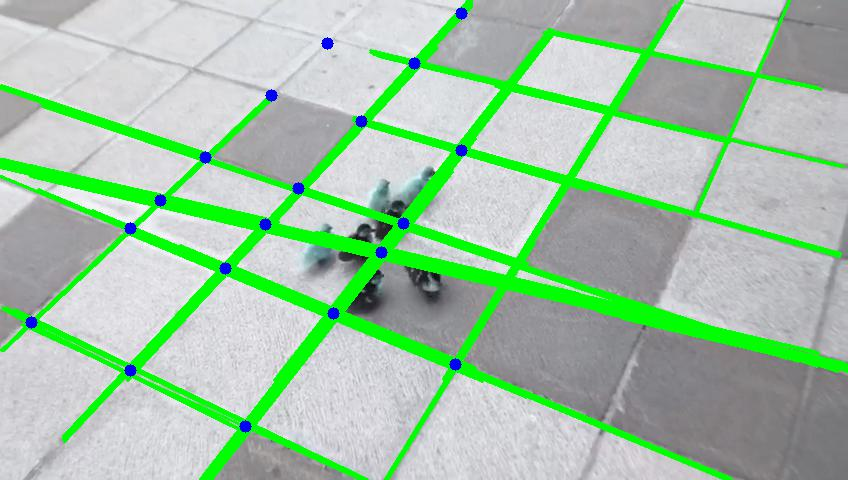

In [9]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(points, quantile=0.025, n_samples=50000)
clustering = MeanShift(bandwidth=bandwidth).fit(points)
centers = clustering.cluster_centers_
cluster_frame = line_img.copy()
for point in centers:
    cv.circle(cluster_frame, center=(point[0].astype('uint32'), point[1].astype('uint32')), thickness=-1, radius=6, color=(0,0,255))
showarray(cluster_frame)

In [7]:
cv.findHomography(centers)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'findHomography'
> Overload resolution failed:
>  - findHomography() missing required argument 'dstPoints' (pos 2)
>  - findHomography() missing required argument 'dstPoints' (pos 2)
>  - findHomography() missing required argument 'dstPoints' (pos 2)
>  - findHomography() missing required argument 'dstPoints' (pos 2)
